In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
import numpy as np
from LinearMPC_template.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")


In [3]:
Ts = 0.05
sim_time = 20
H = 10
x0 = np.zeros(12) # initial state
x0[5] = 40  # roll 
x0[6] = 5.0  # initial vx
x0[7] = 5.0  # initial vy
x0[8] = 5.0  # initial vz# initial wy
#on doit changer un des parametres de xo pour mettre une vitesse dans la direction voulue 
# X -> Xo(6) = Vx, Y-> XO(7) = Vy, Z-> Xo(8) = Vz

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, method="linear"
)


vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Simulating time 0.00: 
 Input Pdiff violation: 40.00 > 20.00, 

ValueError: Constraints violation detected, terminating...

In [4]:
from LinearMPC_template.MPCControl_xvel import MPCControl_xvel
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)
mpc_x = MPCControl_xvel(A, B, xs, us, Ts, H) # Full 12x12 A and 12x4 B matrices
x0_sub = x0[mpc_x.x_ids]   # shape (3,)
u0, x_traj, u_traj = mpc_x.get_u(x0_sub)


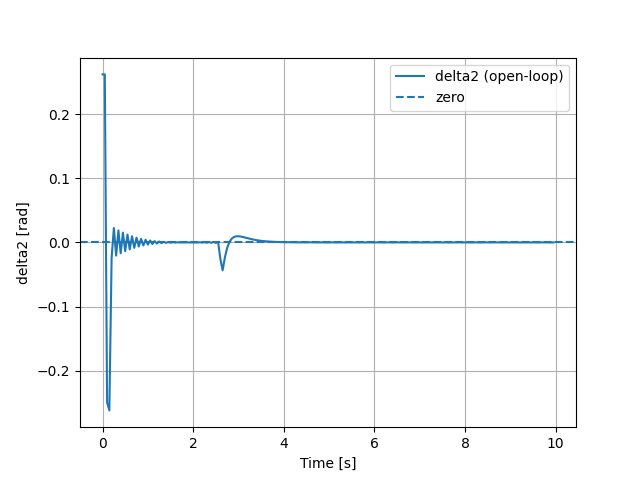

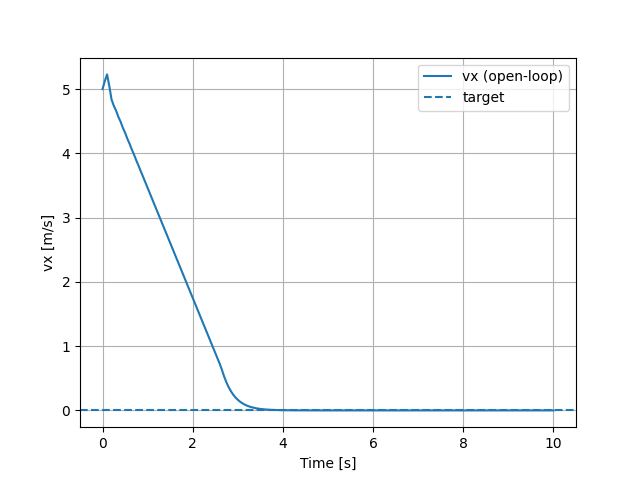

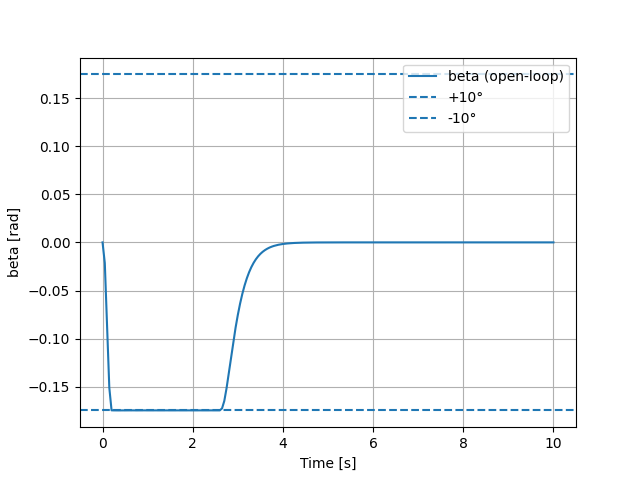

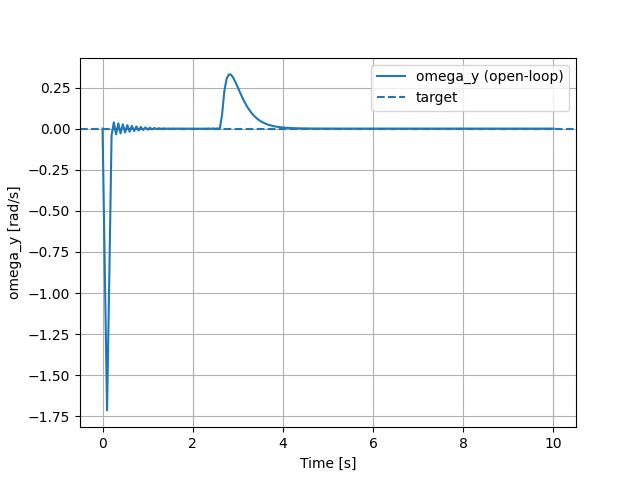

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_x_open_loop(mpc_x, x_traj, u_traj):
    Ts = mpc_x.Ts
    N = mpc_x.N
    t_x = np.arange(N + 1) * Ts
    t_u = np.arange(N) * Ts

    omega_y = x_traj[0, :]
    beta    = x_traj[1, :]
    vx      = x_traj[2, :]
    delta2  = u_traj[0, :]

    beta_max = np.deg2rad(10.0)

    plt.figure()
    plt.plot(t_x, vx, label="vx (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target")
    plt.xlabel("Time [s]")
    plt.ylabel("vx [m/s]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_x, beta, label="beta (open-loop)")
    plt.axhline(+beta_max, linestyle="--", label="+10°")
    plt.axhline(-beta_max, linestyle="--", label="-10°")
    plt.xlabel("Time [s]")
    plt.ylabel("beta [rad]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_x, omega_y, label="omega_y (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target")
    plt.xlabel("Time [s]")
    plt.ylabel("omega_y [rad/s]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_u, delta2, label="delta2 (open-loop)")
    plt.axhline(0.0, linestyle="--", label="zero")
    plt.xlabel("Time [s]")
    plt.ylabel("delta2 [rad]")
    plt.grid(True)
    plt.legend()

# call it
plot_x_open_loop(mpc_x, x_traj, u_traj)
plt.show()


In [ ]:
from LinearMPC_template.MPCControl_yvel import MPCControl_yvel
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)
mpc_y = MPCControl_yvel(A, B, xs, us, Ts, H) # Full 12x12 A and 12x4 B matrices
x0_sub = x0[mpc_y.x_ids]   # shape (3,)
u0, x_traj, u_traj = mpc_y.get_u(x0_sub)

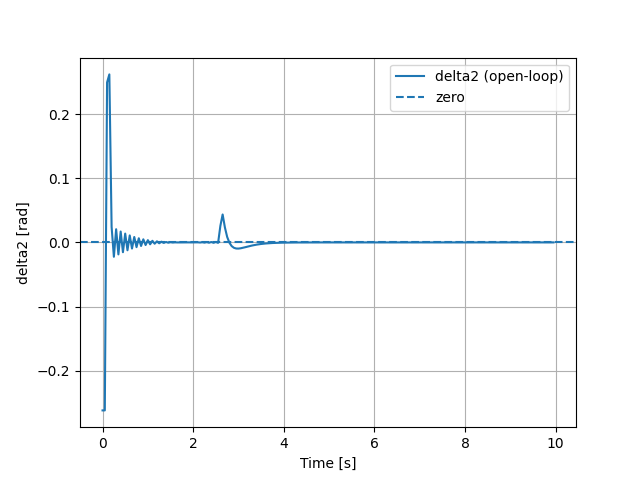

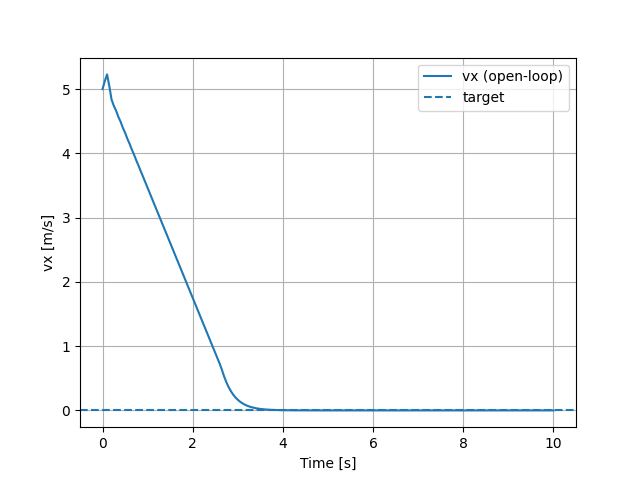

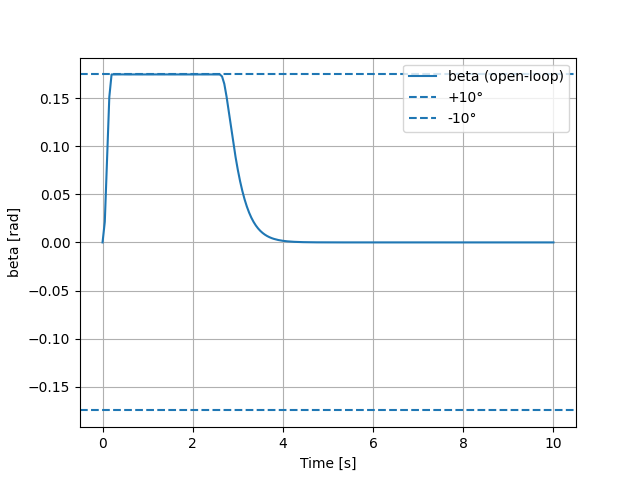

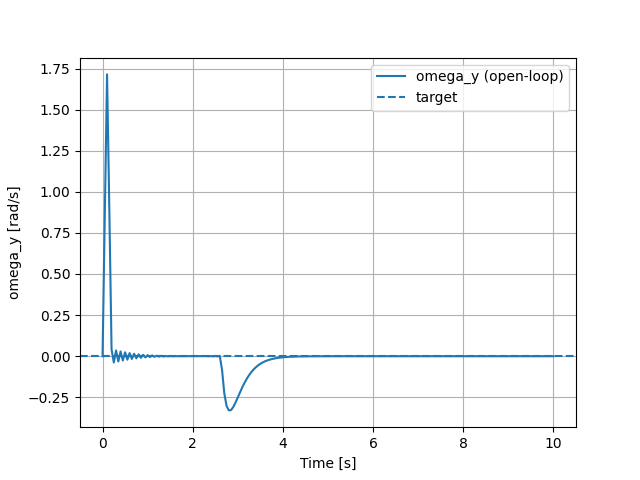

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_y_open_loop(mpc_y, x_traj, u_traj):
    Ts = mpc_y.Ts
    N = mpc_y.N
    t_x = np.arange(N + 1) * Ts
    t_u = np.arange(N) * Ts

    omega_y = x_traj[0, :]
    beta    = x_traj[1, :]
    vx      = x_traj[2, :]
    delta2  = u_traj[0, :]

    beta_max = np.deg2rad(10.0)

    plt.figure()
    plt.plot(t_x, vx, label="vx (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target")
    plt.xlabel("Time [s]")
    plt.ylabel("vx [m/s]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_x, beta, label="beta (open-loop)")
    plt.axhline(+beta_max, linestyle="--", label="+10°")
    plt.axhline(-beta_max, linestyle="--", label="-10°")
    plt.xlabel("Time [s]")
    plt.ylabel("beta [rad]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_x, omega_y, label="omega_y (open-loop)")
    plt.axhline(0.0, linestyle="--", label="target")
    plt.xlabel("Time [s]")
    plt.ylabel("omega_y [rad/s]")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(t_u, delta2, label="delta2 (open-loop)")
    plt.axhline(0.0, linestyle="--", label="zero")
    plt.xlabel("Time [s]")
    plt.ylabel("delta2 [rad]")
    plt.grid(True)
    plt.legend()

# call it
plot_x_open_loop(mpc_x, x_traj, u_traj)
plt.show()


In [ ]:
from LinearMPC_template.MPCControl_zvel import MPCControl_zvel
xs, us = rocket.trim()
A, B = rocket.linearize(xs, us)
mpc_z = MPCControl_zvel(A, B, xs, us, Ts, H) # Full 12x12 A and 12x4 B matrices
x0_sub = x0[mpc_z.x_ids]   # shape (3,)
u0, x_traj, u_traj = mpc_z.get_u(x0_sub)

u_traj min/max: 66.66666547872445 66.66666656686174
mpc_z.us: [66.66666667]


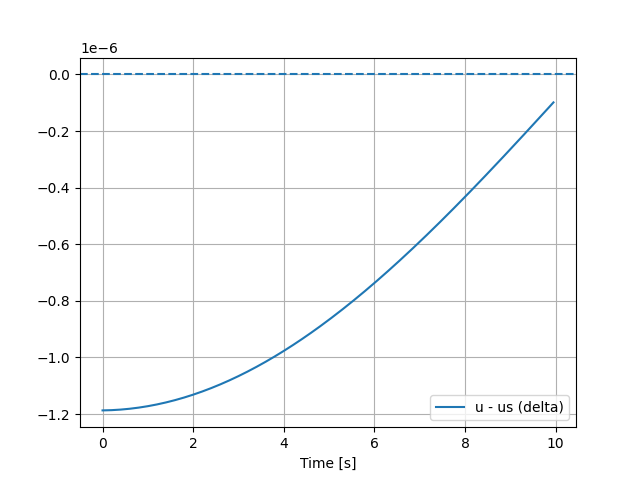

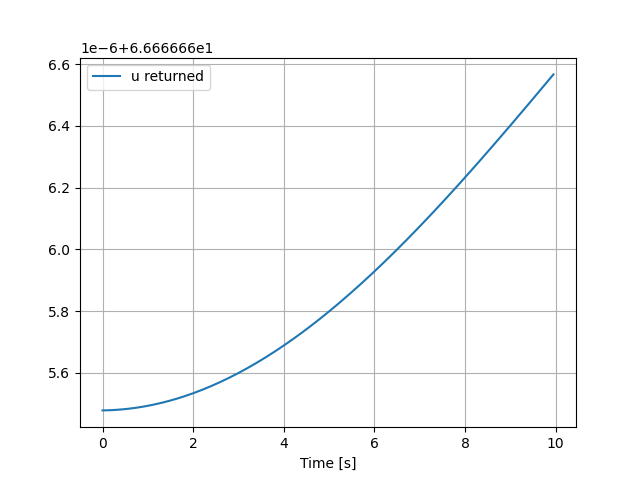

In [ ]:
# u_traj is what your get_u returns
# check if it's delta or absolute
print("u_traj min/max:", u_traj.min(), u_traj.max())
print("mpc_z.us:", mpc_z.us)

u_abs = u_traj  # if already absolute
u_delta = u_traj - mpc_z.us.reshape(-1,1)

import matplotlib.pyplot as plt
t_u = np.arange(mpc_z.N) * mpc_z.Ts

plt.figure()
plt.plot(t_u, u_traj[0,:], label="u returned")
plt.legend(); plt.grid(True); plt.xlabel("Time [s]")

plt.figure()
plt.plot(t_u, u_delta[0,:], label="u - us (delta)")
plt.axhline(0, linestyle="--")
plt.legend(); plt.grid(True); plt.xlabel("Time [s]")
plt.show()


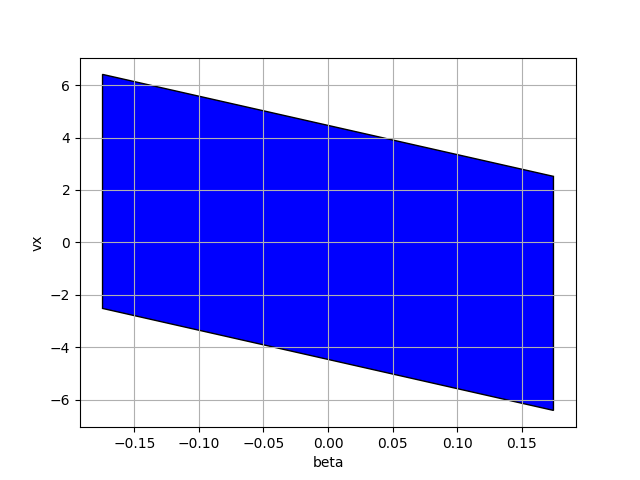

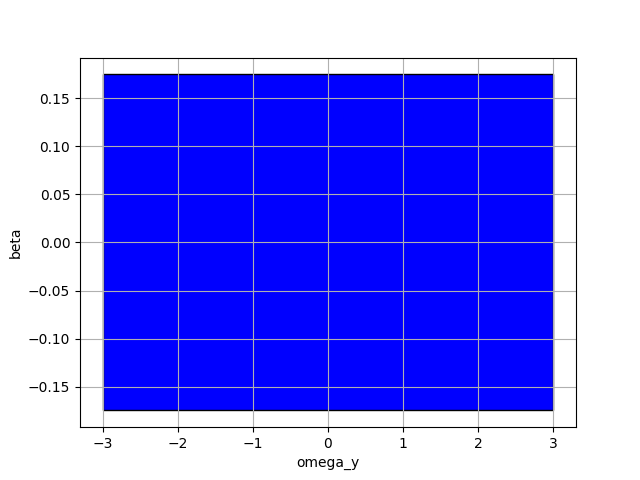

In [ ]:
import matplotlib.pyplot as plt

Xf = mpc_x.Xf  # however you store it

fig, ax = plt.subplots()
Xf.projection(dims=(0,1)).plot(ax=ax)
ax.set_xlabel("omega_y")
ax.set_ylabel("beta")
ax.grid(True)

fig, ax = plt.subplots()
Xf.projection(dims=(1,2)).plot(ax=ax)
ax.set_xlabel("beta")
ax.set_ylabel("vx")
ax.grid(True)

plt.show()


In [ ]:
import inspect
from mpt4py import Polyhedron
print(Polyhedron)
print(inspect.signature(Polyhedron))
print([m for m in dir(Polyhedron) if "proj" in m.lower() or "plot" in m.lower()])


<class 'mpt4py.geometry.polyhedron.Polyhedron'>
(H: Optional[mpt4py.base.HData] = None, V: Optional[mpt4py.base.VData] = None)
['plot', 'project', 'projection']
